In [60]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 100
from datetime import datetime
import itertools
import os, random, math, time
import openpyxl
from tqdm import tqdm
from copy import deepcopy
from collections import Counter
import pandas_profiling
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [61]:
DATA_PATH = '/Users/suyeon/Desktop/Yonsei/course3/ML/assignment'
data_name = 'starbucks.xlsx'

In [62]:
df = pd.read_excel(os.path.join(DATA_PATH, data_name), index_col = 0)

# 데이터

In [63]:
df.head(5)

event  time  offer_id  gender  age  income  member_year  \
0   offer received     0         6       0   75  100000         2017   
1     offer viewed     6         6       0   75  100000         2017   
2  offer completed   132         6       0   75  100000         2017   
3   offer received   168         5       0   75  100000         2017   
4     offer viewed   216         5       0   75  100000         2017   

   member_month  member_day  members_since_in_days  member_since_year  reward  \
0             5           9                   1646                  4       5   
1             5           9                   1646                  4       5   
2             5           9                   1646                  4       5   
3             5           9                   1646                  4       0   
4             5           9                   1646                  4       0   

   difficulty  duration  offer_type  email  web  mobile  social  customer_ids  
0           5         7           0      1    1       1       0             1  
1           5         7           0      1    1       1       0             1  
2           5         7           0      1    1       1       0             1  
3           0         3           2      1    0       1       1             1  
4           0         3           2      1    0       1       1             1

In [64]:
df.shape

(148805, 20)

In [65]:
df.isna().sum()

#결측치 비율 확인
#df.isna().sum(axis = 0)/df.shape[0]

event                    0
time                     0
offer_id                 0
gender                   0
age                      0
income                   0
member_year              0
member_month             0
member_day               0
members_since_in_days    0
member_since_year        0
reward                   0
difficulty               0
duration                 0
offer_type               0
email                    0
web                      0
mobile                   0
social                   0
customer_ids             0
dtype: int64

In [66]:
df[df.offer_type == 2]['event'].unique() #offer_type=2인 경우는 offer_completed가 없기 때문에 informational

array(['offer received', 'offer viewed'], dtype=object)

In [67]:
df = df[df.offer_type != 2].reset_index(drop=True) #offer_type=2인 informational 제거
df.shape

(126145, 20)

In [68]:
df = df.drop_duplicates(keep='first').reset_index(drop=True) #행의 정보가 완전히 겹치는 duplicated row 제거
df.shape

(125771, 20)

### Y변수 : event (categorical)
### offer 보냈을 때 completed 여부를 예측하기 위해서는 offer별로 데이터가 unique 해야 함

In [69]:
df = pd.get_dummies(df, columns=['event'])

In [70]:
df = df.groupby(['offer_id', 'gender', 'age', 'income', 'member_year',
                 'member_month', 'member_day', 'members_since_in_days',
                 'member_since_year', 'reward', 'difficulty', 'duration', 'offer_type',
                 'email', 'web', 'mobile', 'social', 'customer_ids']).max().reset_index()

In [71]:
df.head()

offer_id  gender  age  income  member_year  member_month  member_day  \
0         0       0   18   31000         2017             9          11   
1         0       0   18   43000         2015            10          25   
2         0       0   18   49000         2017             5          24   
3         0       0   18   53000         2013            10           7   
4         0       0   18   73000         2017             2          23   

   members_since_in_days  member_since_year  reward  difficulty  duration  \
0                   1521                  4       5          20        10   
1                   2208                  6       5          20        10   
2                   1631                  4       5          20        10   
3                   2956                  8       5          20        10   
4                   1721                  4       5          20        10   

   offer_type  email  web  mobile  social  customer_ids  time  \
0           1      1    1       0       0         10090   156   
1           1      1    1       0       0          4443   360   
2           1      1    1       0       0            94   168   
3           1      1    1       0       0         11706   558   
4           1      1    1       0       0         13414   612   

   event_offer completed  event_offer received  event_offer viewed  
0                      0                     1                   1  
1                      1                     1                   0  
2                      0                     1                   0  
3                      1                     1                   0  
4                      1                     1                   0

In [72]:
df.shape

(44181, 22)

In [73]:
df.columns

Index(['offer_id', 'gender', 'age', 'income', 'member_year', 'member_month',
       'member_day', 'members_since_in_days', 'member_since_year', 'reward',
       'difficulty', 'duration', 'offer_type', 'email', 'web', 'mobile',
       'social', 'customer_ids', 'time', 'event_offer completed',
       'event_offer received', 'event_offer viewed'],
      dtype='object')

### Profile Resport

In [46]:
profile_report = df.profile_report()

In [47]:
profile_report

Render HTML: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


- email : 모든 행에 대해 1의 값 -> 제거
- event_offer received : 모든 행에 대해 1의 값 -> 제거
- event_offer viewed : offer 보내는 시점에서 알 수 있는 변수가 아님 -> 제거
- customer_ids : 같은 고객 여부보다는 나이와 성별 정보 + offer 정보만으로 offer 결과를 확인하는 것이 offer 건수마다 분류 가능할 것 같음 -> 제거
- time : offer 보내는 시점에서 알 수 있는 변수가 아님 -> 제거
- member_since_year : member_year과의 correlation = 1 -> 제거

In [74]:
df = df.drop(['email', 'event_offer received', 'event_offer viewed', 'customer_ids','time', 'member_since_year'], axis = 1)

### 파생변수 ->  제품가격 대비 혜택가격의 비율 변수 생성

- BOGO : reward = difficulty (제품가격 = 혜택가격)
- Discount : reward != difficulty


In [75]:
df[(df.reward==df.difficulty)]['offer_type'].unique()

array([0])

In [76]:
# reward_diff_rt : 제품가격 대비 혜택가격의 비율 변수
df['reward_diff_rt'] = df.reward/df.difficulty

In [77]:
df.columns

Index(['offer_id', 'gender', 'age', 'income', 'member_year', 'member_month',
       'member_day', 'members_since_in_days', 'reward', 'difficulty',
       'duration', 'offer_type', 'web', 'mobile', 'social',
       'event_offer completed', 'reward_diff_rt'],
      dtype='object')

In [78]:
df.shape

(44181, 17)

In [79]:
df.dtypes

offer_id                   int64
gender                     int64
age                        int64
income                     int64
member_year                int64
member_month               int64
member_day                 int64
members_since_in_days      int64
reward                     int64
difficulty                 int64
duration                   int64
offer_type                 int64
web                        int64
mobile                     int64
social                     int64
event_offer completed      uint8
reward_diff_rt           float64
dtype: object

In [80]:
con_col = ['age', 'income', 'member_month', 'member_day', 'members_since_in_days']
int_col = ['offer_id', 'gender', 'reward', 'difficulty', 'duration', 'offer_type',
           'web', 'mobile', 'social', 'event_offer completed', 'reward_diff_rt', 'member_year']

In [81]:
df_info = deepcopy(df)

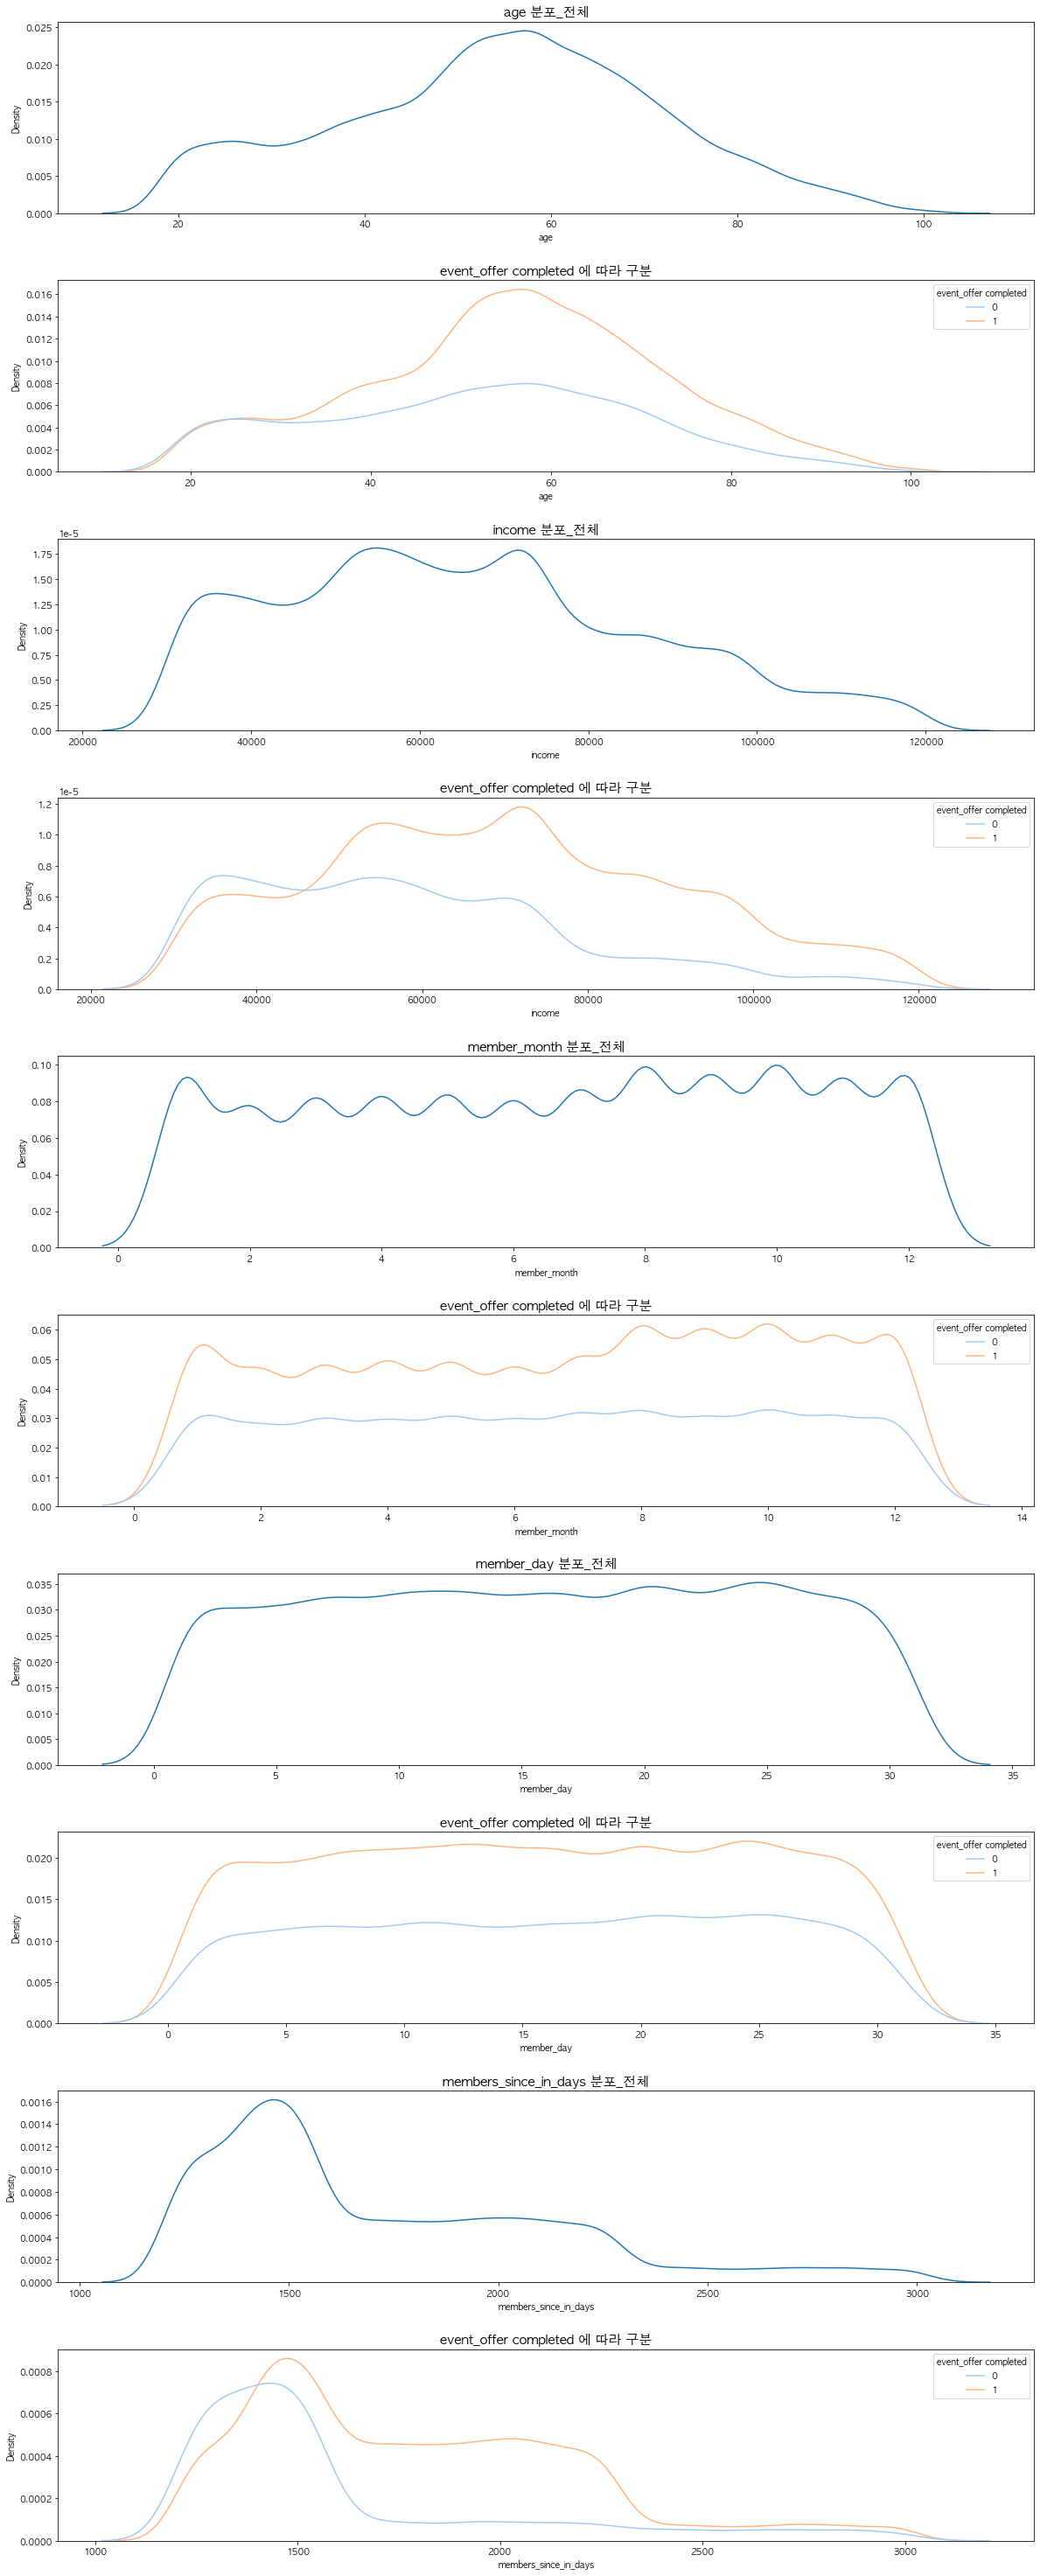

In [56]:
n = len(con_col)
fig,ax = plt.subplots(n*2,1,figsize=(20,5*n*2))

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

for ind, i in enumerate(con_col): 
    sns.kdeplot(df_info[i], palette = "pastel", ax=ax[ind*2])
    ax[ind*2].set_title("{} 분포_전체".format(i), fontsize = 15)
    sns.kdeplot(df_info[i], palette = "pastel", ax=ax[ind*2+1], hue = df_info['event_offer completed'])
    ax[ind*2+1].set_title("{} 에 따라 구분".format('event_offer completed'), fontsize = 15)

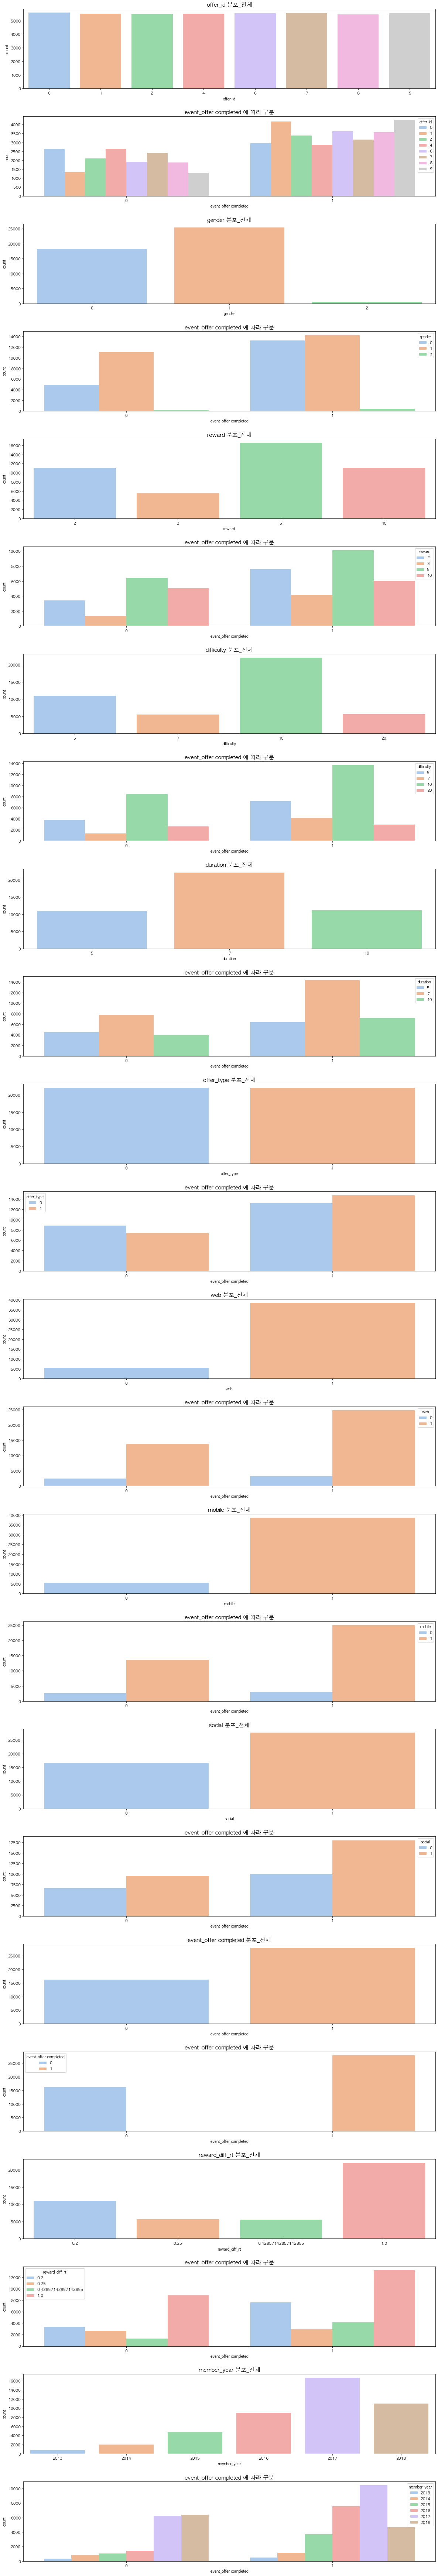

In [57]:
n = len(int_col)
fig,ax = plt.subplots(n*2,1,figsize=(20,5*n*2))

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

for ind, i in enumerate(int_col): 
    sns.countplot(df_info[i], palette = "pastel", ax=ax[ind*2])
    ax[ind*2].set_title("{} 분포_전체".format(i), fontsize = 15)
    sns.countplot(df_info['event_offer completed'], palette = "pastel", ax=ax[ind*2+1], hue = df_info[i])
    ax[ind*2+1].set_title("{} 에 따라 구분".format('event_offer completed'), fontsize = 15)

### 명목형 변수 : offer_id, gender

In [82]:
cat_col = ['offer_id', 'gender']

for i in cat_col:
    df[i] = df[i].astype('object')
   
df_dummy = pd.get_dummies(df, columns=cat_col, drop_first=True)

In [109]:
df.dtypes

offer_id                  object
gender                    object
age                        int64
income                     int64
member_year                int64
member_month               int64
member_day                 int64
members_since_in_days      int64
reward                     int64
difficulty                 int64
duration                   int64
offer_type                 int64
web                        int64
mobile                     int64
social                     int64
event_offer completed      uint8
reward_diff_rt           float64
dtype: object

## 모델링

1) train set만 학습하여 기본 파라미터를 사용한 머신러닝 모형들의 성능을 비교하고 가장 뛰어난 모형 선택
2) 선택된 모형의 train set만 Grid search하여 하이퍼파라미터 튜닝한 후 모델 성능 높이기
3) 최종 test set에 적용하고 결과를 비교하여 튜닝한 모형 or 튜닝하지 않은 모형 정하기

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

- test : train = 3: 7
- Y : binary -> bagging, boosting classifier 사용

In [110]:
y = deepcopy(df_dummy['event_offer completed'])
X = deepcopy(df_dummy.drop(['event_offer completed'], axis=1))

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [112]:
X_train

age  income  member_year  member_month  member_day  \
7840    99  111000         2017             8          29   
25480   46   65000         2017            10           4   
41985   45   51000         2017            10          14   
11884   52   70000         2017            10          29   
18728   85   97000         2016             5          29   
...    ...     ...          ...           ...         ...   
32399   65   90000         2018             2          13   
17048   44   69000         2018             3          21   
23924   71   97000         2018             3          10   
34086   54   62000         2017             9          22   
27439   83   56000         2017             4          27   

       members_since_in_days  reward  difficulty  duration  offer_type  web  \
7840                    1534       3           7         7           1    1   
25480                   1498       5           5         7           0    1   
41985                   1488       2          10        10           1    1   
11884                   1473       2          10         7           1    1   
18728                   1991      10          10         5           0    1   
...                      ...     ...         ...       ...         ...  ...   
32399                   1366      10          10         7           0    0   
17048                   1330      10          10         5           0    1   
23924                   1341       5           5         7           0    1   
34086                   1510       5           5         5           0    1   
27439                   1658       5           5         7           0    1   

       mobile  social  reward_diff_rt  offer_id_1  offer_id_2  offer_id_4  \
7840        1       1          0.4286           1           0           0   
25480       1       0          1.0000           0           0           0   
41985       1       1          0.2000           0           0           0   
11884       1       0          0.2000           0           1           0   
18728       1       1          1.0000           0           0           1   
...       ...     ...             ...         ...         ...         ...   
32399       1       1          1.0000           0           0           0   
17048       1       1          1.0000           0           0           1   
23924       1       0          1.0000           0           0           0   
34086       1       1          1.0000           0           0           0   
27439       1       0          1.0000           0           0           0   

       offer_id_6  offer_id_7  offer_id_8  offer_id_9  gender_1  gender_2  
7840            0           0           0           0         0         0  
25480           1           0           0           0         1         0  
41985           0           0           0           1         1         0  
11884           0           0           0           0         0         0  
18728           0           0           0           0         0         0  
...           ...         ...         ...         ...       ...       ...  
32399           0           1           0           0         1         0  
17048           0           0           0           0         0         0  
23924           1           0           0           0         0         0  
34086           0           0           1           0         0         0  
27439           1           0           0           0         1         0  

[30926 rows x 23 columns]

In [113]:
y_train

7840     1
25480    1
41985    1
11884    1
18728    1
        ..
32399    0
17048    0
23924    1
34086    1
27439    1
Name: event_offer completed, Length: 30926, dtype: uint8

In [97]:
# 모델 학습
model1 = DecisionTreeClassifier(random_state=1234)
model1.fit(X_train, y_train)

model2 = RandomForestClassifier(random_state=1234)
model2.fit(X_train, y_train)

model3 = GradientBoostingClassifier(random_state=1234)
model3.fit(X_train, y_train)

model4 = XGBClassifier(random_state=1234)
model4.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1234, ...)

In [98]:
# 예측 라벨과 실제 라벨 사이의 정확도 측정
print("model1 : ", accuracy_score(model1.predict(X_test), y_test))
print("model2 : ", accuracy_score(model2.predict(X_test), y_test))
print("model3 : ", accuracy_score(model3.predict(X_test), y_test))
print("model4 : ", accuracy_score(model4.predict(X_test), y_test))

model1 :  0.6743870237646171
model2 :  0.7099962278385515
model3 :  0.7360995850622407
model4 :  0.7425122595247077


### Grid search

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [118]:
params = {'max_depth': [6, 8, 10], 
          'min_child_weight': [0.01, 0.05, 0.1],
          'gamma' : [0, 1, 2]
          }

- max_depth : 트리의 최대 깊이 (= 루트에서 가장 긴 노드의 거리) (typical value : 3-10)
- min_chld_wieght : 값이 높아지면 under-fitting -> 튜낭 필요
- gamma : 노드가 Split 되기 위한 loss function 값이 감소하는 최솟값 / 높아질수록 보수적으로 변함 -> 튜닝 필요

In [119]:
grid_search = GridSearchCV(estimator=model4, param_grid=params, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .........gamma=0, max_depth=6, min_child_weight=0.1; total time=   4.4s
[CV] END ........gamma=0, max_depth=6, min_child_weight=0.05; total time=   4.6s
[CV] END .........gamma=0, max_depth=6, min_child_weight=0.1; total time=   4.7s
[CV] END ........gamma=0, max_depth=6, min_child_weight=0.05; total time=   4.7s
[CV] END ........gamma=0, max_depth=6, min_child_weight=0.01; total time=   4.8s
[CV] END ........gamma=0, max_depth=6, min_child_weight=0.01; total time=   4.8s
[CV] END ........gamma=0, max_depth=6, min_child_weight=0.01; total time=   4.9s
[CV] END ........gamma=0, max_depth=6, min_child_weight=0.05; total time=   5.0s
[CV] END .........gamma=0, max_depth=6, min_child_weight=0.1; total time=   4.8s
[CV] END ........gamma=0, max_depth=8, min_child_weight=0.01; total time=   6.0s
[CV] END ........gamma=0, max_depth=8, min_child_weight=0.01; total time=   5.8s
[CV] END .........gamma=0, max_depth=8, min_chil

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1234, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 1, 2], 'max_depth': [6, 8, 10],
                         'min_child_weight': [0.01, 0.05, 0.1]},
             verbose=2)

In [120]:
# 최적의 파라미터 값 / 최고의 점수 출력
grid_search.best_params_, grid_search.best_score_

({'gamma': 1, 'max_depth': 6, 'min_child_weight': 0.1}, 0.7333958705993844)

In [121]:
# 정확도 측정
print("grid_search : ", accuracy_score(grid_search.predict(X_test), y_test))

grid_search :  0.7400226329686911


In [122]:
# 최적의 파라미터로 모델 생성
model4_tunned = XGBClassifier(random_state=1234, gamma=1, max_depth=6, min_child_weight=0.1)
model4_tunned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0.1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1234, ...)

In [123]:
print("model4_tunned : ", accuracy_score(model4_tunned.predict(X_test), y_test)) # 파라미터 튜닝 모델 사용 X

model4_tunned :  0.7400226329686911


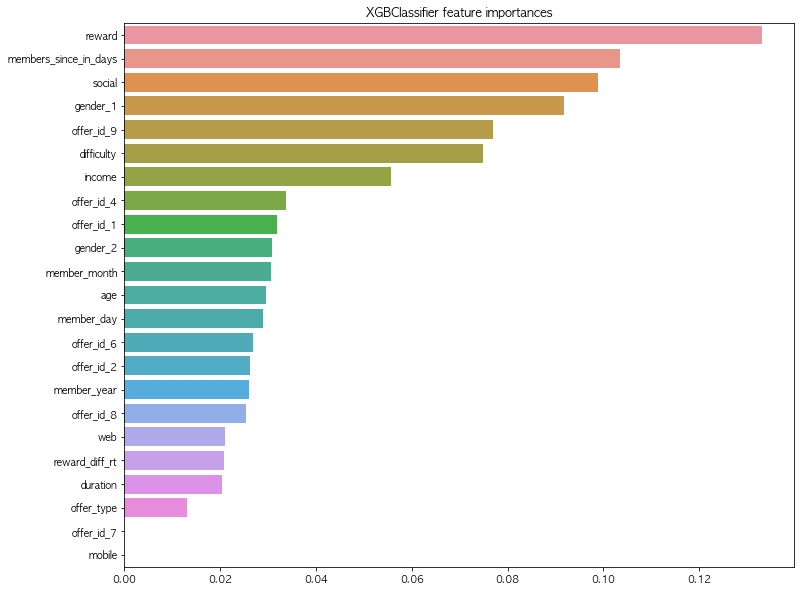

In [126]:
# 기본 모델의 feature importance plot 확인

ft_importances1 = pd.Series(model4.feature_importances_, index=X_test.columns)
ft_importances1 = ft_importances1.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("XGBClassifier feature importances")
sns.barplot(x=ft_importances1, y=ft_importances1.index)
plt.show()

In [133]:
ft_importances1.shape

(23,)

In [141]:
# 하위 변수 제거
ft_col1 = ft_importances1[:21].index
ft_col1 = ft_col1.to_list()
ft_col1

['reward',
 'members_since_in_days',
 'social',
 'gender_1',
 'offer_id_9',
 'difficulty',
 'income',
 'offer_id_4',
 'offer_id_1',
 'gender_2',
 'member_month',
 'age',
 'member_day',
 'offer_id_6',
 'offer_id_2',
 'member_year',
 'offer_id_8',
 'web',
 'reward_diff_rt',
 'duration',
 'offer_type']

In [142]:
model4_ft = model4.fit(X_train[ft_col1], y_train)
print("model4_ft : ", accuracy_score(model4_ft.predict(X_test[ft_col1]), y_test))

model4_ft :  0.7425877027536778


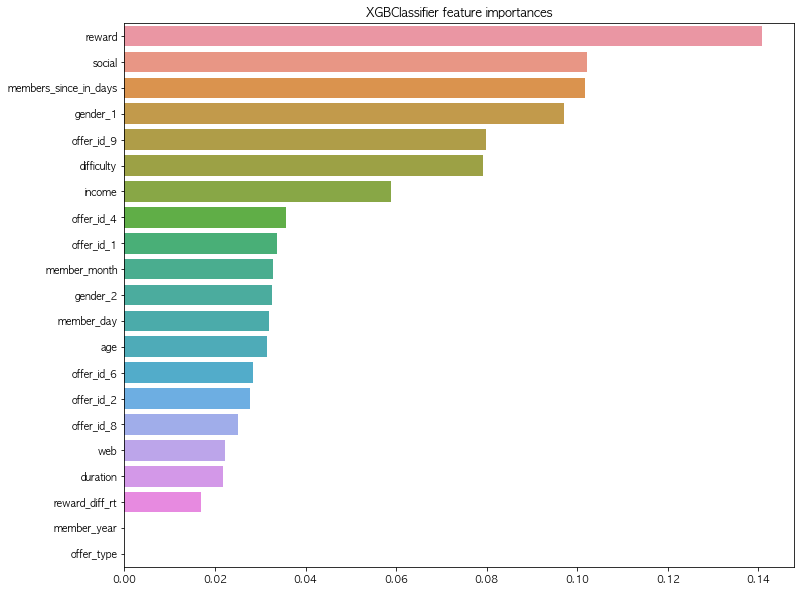

In [143]:
ft_importances2 = pd.Series(model4.feature_importances_, index=ft_col1)
ft_importances2 = ft_importances2.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("XGBClassifier feature importances")
sns.barplot(x=ft_importances2, y=ft_importances2.index)
plt.show()

In [144]:
ft_importances2.shape

(21,)

In [145]:
# 하위 변수 제거
ft_col2 = ft_importances2[:19].index
ft_col2 = ft_col2.to_list()
ft_col2

['reward',
 'social',
 'members_since_in_days',
 'gender_1',
 'offer_id_9',
 'difficulty',
 'income',
 'offer_id_4',
 'offer_id_1',
 'member_month',
 'gender_2',
 'member_day',
 'age',
 'offer_id_6',
 'offer_id_2',
 'offer_id_8',
 'web',
 'duration',
 'reward_diff_rt']